In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df=pd.read_csv("/Users/prateekb/Downloads/MyPrograms/Certification/WIP/Machine Learning/Time Series/SeaPlaneTravel.csv")
df.rename(columns={'#Passengers':'Passengers'},inplace=True)
df['Month']=pd.to_datetime(df['Month'])
df=df.set_index('Month')

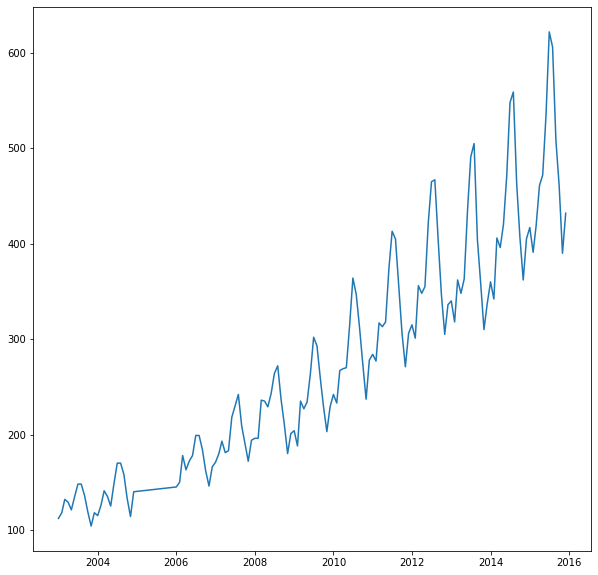

In [127]:
plt.figure(figsize=(10,10))
plt.plot(df['Passengers'])

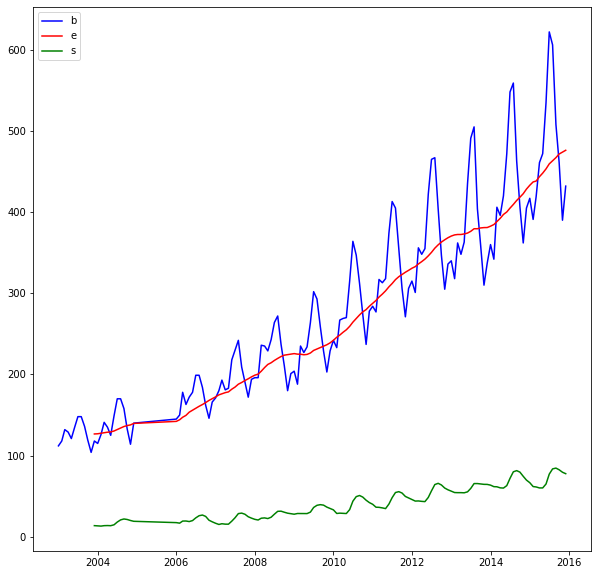

The test result for Augmented Dickey Fuller is 0.991880


In [128]:
def rollingStatPlot(df):
    tsMean=df.rolling(12).mean()
    tsSd=df.rolling(12).std()
    plt.figure(figsize=(10,10))
    plt.plot(df,color='blue',label='original')
    plt.plot(tsMean,color='red',label='tsMean')
    plt.plot(tsSd,color='green',label='tsSd')
    plt.legend('best')
    plt.show()
    
    from statsmodels.tsa.stattools import adfuller
    test=adfuller(df)
    print("The test result for Augmented Dickey Fuller is %f"%(test[1]))
    
rollingStatPlot(df)


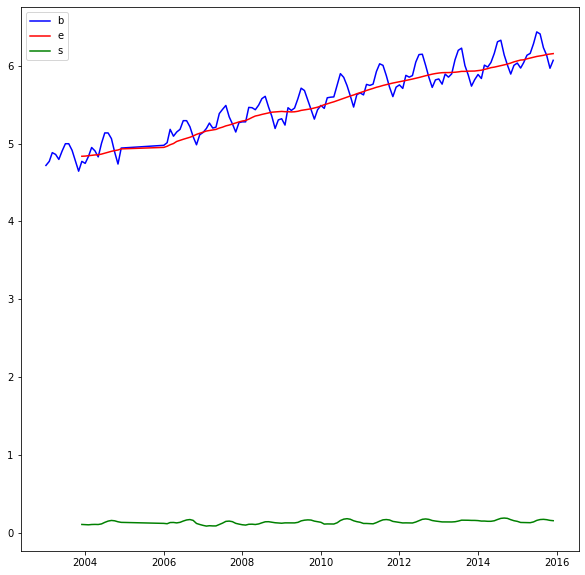

The test result for Augmented Dickey Fuller is 0.422367


In [129]:
#we take a log to tranform the data to penalize higher values 
tsLog=np.log(df)
rollingStatPlot(tsLog)


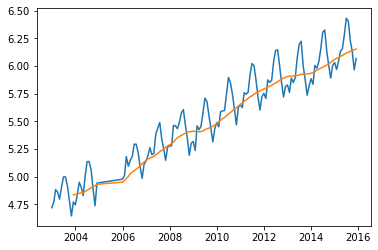

In [130]:
movingAverage=tsLog.rolling(12).mean()
plt.plot(tsLog)
plt.plot(movingAverage)

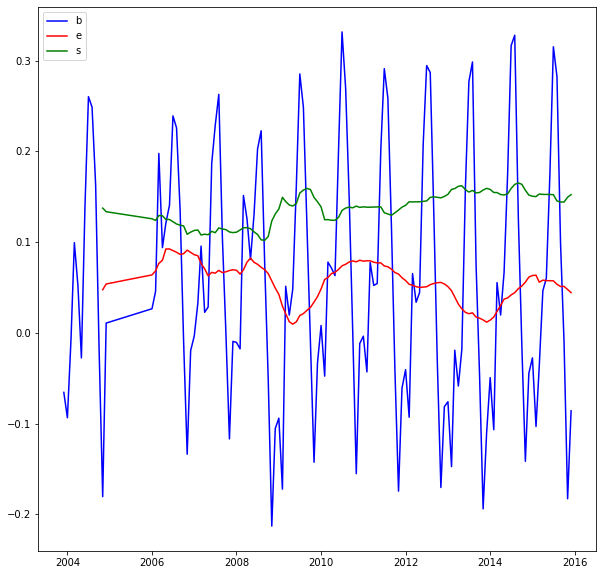

The test result for Augmented Dickey Fuller is 0.022235


,Passengers
Month,
2003-12-01,-0.065494
2004-01-01,-0.093449
2004-02-01,-0.007566
2004-03-01,0.099416
2004-04-01,0.052142
...,...
2015-08-01,0.282363
2015-09-01,0.098235
2015-10-01,-0.009230


In [153]:
logAndMA=tsLog-movingAverage
logAndMA.dropna(inplace=True)
rollingStatPlot(logAndMA)

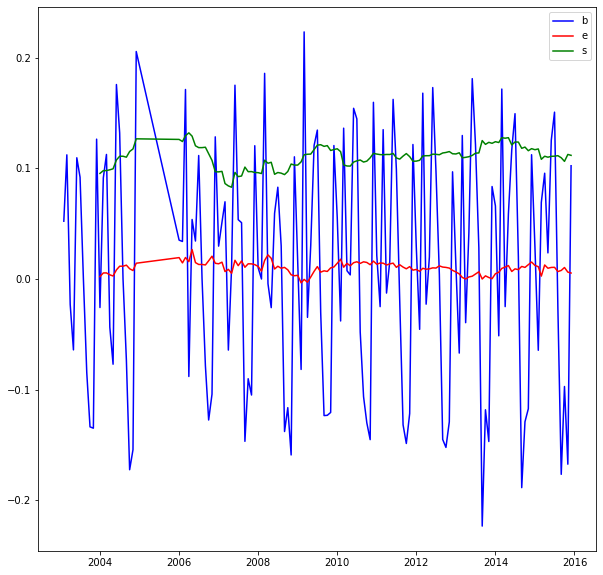

The test result for Augmented Dickey Fuller is 0.071121


In [132]:
diff=tsLog-tsLog.shift()
diff.dropna(inplace=True)
rollingStatPlot(diff)

In [152]:
diff

,Passengers
Month,
2003-02-01,0.052186
2003-03-01,0.112117
2003-04-01,-0.022990
2003-05-01,-0.064022
2003-06-01,0.109484
...,...
2015-08-01,-0.026060
2015-09-01,-0.176399
2015-10-01,-0.097083


/Users/prateekb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/stattools.py:572: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  FutureWarning


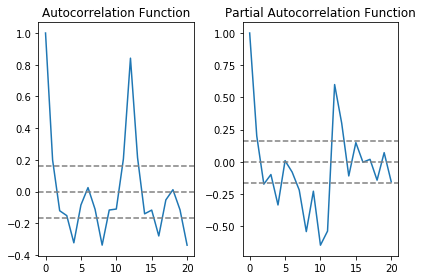

In [154]:
from statsmodels.graphics.tsaplots import acf,pacf

acfLag=acf(diff,nlags=20)
pacfLag=pacf(diff,nlags=20,method='ols')

plt.subplot(121) 
plt.plot(acfLag)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(pacfLag)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

/Users/prateekb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Text(0.5, 1.0, 'RSS: 1.0292')

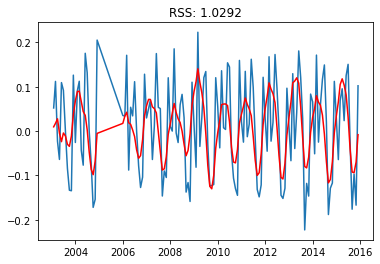

In [134]:
#trainSize=int(len(tsLog)*.95)
#train_data,test_data=tsLog[0:trainSize],tsLog[trainSize:]

from statsmodels.tsa.arima_model import ARIMA
model=ARIMA(tsLog,order=(2,1,2))
result=model.fit(disp=-1)
plt.plot(diff)
plt.plot(result.fittedvalues, color='red')
plt.title('RSS: %.4f'% sum((result.fittedvalues-diff['Passengers'])**2))

In [137]:
predictions_ARIMA_diff = pd.Series(result.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

Month
2003-02-01    0.009580
2003-03-01    0.017491
2003-04-01    0.027670
2003-05-01   -0.004521
2003-06-01   -0.023890
dtype: float64


In [138]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())



Month
2003-02-01    0.009580
2003-03-01    0.027071
2003-04-01    0.054742
2003-05-01    0.050221
2003-06-01    0.026331
dtype: float64


In [143]:
predictions_ARIMA_log = pd.Series(tsLog['Passengers'].ix[0], index=tsLog.index)


AttributeError: 'Series' object has no attribute 'ix'

In [145]:
predictions_ARIMA_log = pd.Series(tsLog['Passengers'], index=tsLog.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
print(predictions_ARIMA_log.head())

Month
2003-01-01    4.718499
2003-02-01    4.780265
2003-03-01    4.909873
2003-04-01    4.914554
2003-05-01    4.846011
dtype: float64


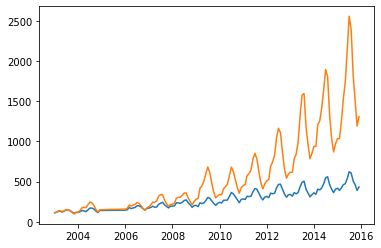

In [147]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df['Passengers'])
plt.plot(predictions_ARIMA)


In [148]:
tsLog

,Passengers
Month,
2003-01-01,4.718499
2003-02-01,4.770685
2003-03-01,4.882802
2003-04-01,4.859812
2003-05-01,4.795791
...,...
2015-08-01,6.406880
2015-09-01,6.230481
2015-10-01,6.133398


/Users/prateekb/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


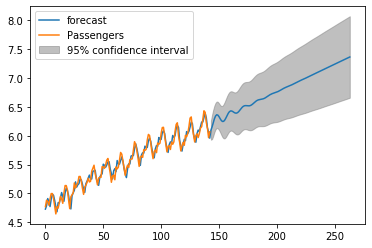

In [151]:
result.plot_predict(1,264)
#x=result.forecast(steps=120)